In [1]:
# libraries
# copy-paste of seminar

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


In [2]:
# load game and look at it

import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

print("state_shape =", state_shape, " n_actions =", n_actions)

state_shape = (8,)  n_actions = 4


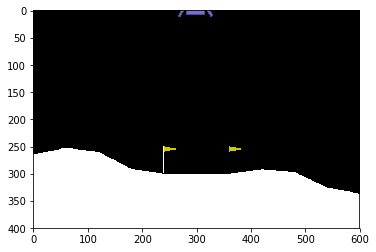

In [3]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [4]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 60, nonlinearity=elu)
nn = DenseLayer(nn, 60, nonlinearity=elu)
nn = DenseLayer(nn, 40, nonlinearity=elu)
nn = DenseLayer(nn, 20, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \varepsilon$ -greedy policy

In [5]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [6]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [8]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

In [9]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

actions: [[1 1 3 1 0]]
rewards: [[-2.36154035 -2.97742629 -0.93022191 -2.8447542   0.        ]]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.78 ms


In [10]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [11]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]


In [12]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [13]:
#get weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [14]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
#untrained_reward = pool.evaluate(save_path="./records",record_video=True)

In [15]:
#show video
# from IPython.display import HTML
# import os

# video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

# HTML("""
# <video width="640" height="480" controls>
#   <source src="{}" type="video/mp4">
# </video>
# """.format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [16]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
#target_score = -90
target_score = 150

In [17]:
from tqdm import trange

lastReward = -500
epoch_counter = 1

for i in trange(3000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        n_games = 10
        lastReward = np.mean(pool.evaluate(n_games=n_games,record_video=False, verbose=False))
        rewards[epoch_counter] = lastReward
        print("Iteration=%i\tEpsilon=%.3f\tCurrent score(mean over %i) = %.3f" % \
              (epoch_counter,action_layer.epsilon.get_value(),n_games, lastReward,))
        print("#" * int((lastReward + 100) // 10))
    
        if rewards[epoch_counter] >= target_score:
            break
    
    epoch_counter  +=1

  3%|▎         | 103/3000 [00:05<02:32, 19.05it/s]

Iteration=100	Epsilon=0.910	Current score(mean over 10) = -321.620



  7%|▋         | 203/3000 [00:11<02:32, 18.33it/s]

Iteration=200	Epsilon=0.828	Current score(mean over 10) = -155.483



 10%|█         | 303/3000 [00:18<02:41, 16.69it/s]

Iteration=300	Epsilon=0.754	Current score(mean over 10) = -127.911



 13%|█▎        | 403/3000 [00:24<02:35, 16.68it/s]

Iteration=400	Epsilon=0.687	Current score(mean over 10) = -174.553



 17%|█▋        | 503/3000 [00:30<02:31, 16.49it/s]

Iteration=500	Epsilon=0.626	Current score(mean over 10) = -186.990



 20%|██        | 601/3000 [00:37<02:28, 16.14it/s]

Iteration=600	Epsilon=0.571	Current score(mean over 10) = -140.857



 23%|██▎       | 703/3000 [00:46<02:31, 15.21it/s]

Iteration=700	Epsilon=0.522	Current score(mean over 10) = -144.755



 27%|██▋       | 802/3000 [00:54<02:30, 14.65it/s]

Iteration=800	Epsilon=0.477	Current score(mean over 10) = -116.544



 30%|███       | 903/3000 [01:04<02:30, 13.92it/s]

Iteration=900	Epsilon=0.436	Current score(mean over 10) = -78.279
##


 33%|███▎      | 1001/3000 [01:15<02:31, 13.19it/s]

Iteration=1000	Epsilon=0.399	Current score(mean over 10) = -88.139
#


 37%|███▋      | 1101/3000 [01:29<02:33, 12.35it/s]

Iteration=1100	Epsilon=0.366	Current score(mean over 10) = -9.461
#########


 40%|████      | 1201/3000 [01:50<02:45, 10.86it/s]

Iteration=1200	Epsilon=0.336	Current score(mean over 10) = -46.292
#####


 43%|████▎     | 1302/3000 [02:14<02:54,  9.71it/s]

Iteration=1300	Epsilon=0.309	Current score(mean over 10) = -53.666
####


 47%|████▋     | 1402/3000 [02:34<02:55,  9.09it/s]

Iteration=1400	Epsilon=0.284	Current score(mean over 10) = 66.001
################


 50%|█████     | 1501/3000 [02:54<02:53,  8.62it/s]

Iteration=1500	Epsilon=0.262	Current score(mean over 10) = 52.767
###############


 53%|█████▎    | 1601/3000 [03:15<02:50,  8.20it/s]

Iteration=1600	Epsilon=0.242	Current score(mean over 10) = -112.835



 57%|█████▋    | 1702/3000 [03:38<02:47,  7.77it/s]

Iteration=1700	Epsilon=0.224	Current score(mean over 10) = -50.149
####


 60%|██████    | 1801/3000 [04:02<02:41,  7.42it/s]

Iteration=1800	Epsilon=0.207	Current score(mean over 10) = -108.394



 63%|██████▎   | 1901/3000 [04:25<02:33,  7.17it/s]

Iteration=1900	Epsilon=0.192	Current score(mean over 10) = -38.524
######


 67%|██████▋   | 2001/3000 [04:46<02:23,  6.99it/s]

Iteration=2000	Epsilon=0.179	Current score(mean over 10) = -14.102
########


 70%|███████   | 2101/3000 [05:06<02:10,  6.86it/s]

Iteration=2100	Epsilon=0.166	Current score(mean over 10) = -103.361



 73%|███████▎  | 2201/3000 [05:28<01:59,  6.70it/s]

Iteration=2200	Epsilon=0.155	Current score(mean over 10) = -124.348



 77%|███████▋  | 2302/3000 [05:51<01:46,  6.54it/s]

Iteration=2300	Epsilon=0.145	Current score(mean over 10) = 35.027
#############


 80%|████████  | 2401/3000 [06:09<01:32,  6.49it/s]

Iteration=2400	Epsilon=0.136	Current score(mean over 10) = 3.070
##########


 83%|████████▎ | 2502/3000 [06:29<01:17,  6.43it/s]

Iteration=2500	Epsilon=0.128	Current score(mean over 10) = -115.341



 87%|████████▋ | 2601/3000 [06:54<01:03,  6.27it/s]

Iteration=2600	Epsilon=0.121	Current score(mean over 10) = -109.357



 90%|█████████ | 2701/3000 [07:09<00:47,  6.29it/s]

Iteration=2700	Epsilon=0.114	Current score(mean over 10) = 33.759
#############


 93%|█████████▎| 2802/3000 [07:21<00:31,  6.35it/s]

Iteration=2800	Epsilon=0.108	Current score(mean over 10) = 49.974
##############


 97%|█████████▋| 2902/3000 [07:38<00:15,  6.33it/s]

Iteration=2900	Epsilon=0.102	Current score(mean over 10) = -188.405



100%|██████████| 3000/3000 [07:50<00:00,  6.37it/s]

Iteration=3000	Epsilon=0.097	Current score(mean over 10) = 170.752
###########################


In [21]:
help(pool.evaluate)

Help on method evaluate in module agentnet.experiments.openai_gym.pool:

evaluate(n_games=1, save_path='./records', use_monitor=True, record_video=True, verbose=True, t_max=100000) method of agentnet.experiments.openai_gym.pool.EnvPool instance
    Plays an entire game start to end, records the logs(and possibly mp4 video), returns reward.
    
    :param save_path: where to save the report
    :param record_video: if True, records mp4 video
    :return: total reward (scalar)



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


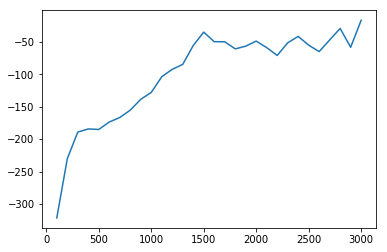

In [22]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(), key=lambda k_v : k_v[0]))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [25]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

Episode finished after 578 timesteps with reward=150.1781822511792
Episode finished after 438 timesteps with reward=182.37513595367844
Episode finished after 391 timesteps with reward=169.42999628389597
Episode finished after 522 timesteps with reward=146.62188134281078
Episode finished after 601 timesteps with reward=183.40391646145395
Episode finished after 603 timesteps with reward=166.75936449141597
Episode finished after 372 timesteps with reward=135.95071115437764
Episode finished after 367 timesteps with reward=158.1252067257443
Episode finished after 485 timesteps with reward=151.79278059817636
Episode finished after 617 timesteps with reward=189.87694394559617
average reward: [150.17818225117921, 182.37513595367844, 169.42999628389597, 146.62188134281078, 183.40391646145395, 166.75936449141597, 135.95071115437764, 158.12520672574431, 151.79278059817636, 189.87694394559617]
